# Reproduce extraction & graph creation


## Extract incidents
- Extract incidents and alerts from the alphine ski house data and save them to csv.

In [2]:
import pandas as pd
import os
import json

# /Users/kevin/Downloads/SecRL/secgym/env/data_anonymized/alphineskihouse/SecurityIncident.csv
# load data
base_path = "/Users/kevin/Downloads/SecRL/secgym/env/data_anonymized/alphineskihouse/"
incident_path = os.path.join(base_path, "SecurityIncident.csv")
sep = "❖"
security_incident = pd.read_csv(incident_path, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')
alert_path_1 = os.path.join(base_path, "SecurityAlert/SecurityAlert_0.csv")
alert_path_2 = os.path.join(base_path, "SecurityAlert/SecurityAlert_1.csv")
security_alert =  pd.read_csv(alert_path_1, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')
security_alert_2 = pd.read_csv(alert_path_2, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')
security_alert = pd.concat([security_alert, security_alert_2])

incident_output_path = "./extracted_incidents.csv"
alert_output_path = "./extracted_alerts.csv"


# ----------------------------------------------------------------------
# ----------------------------------------------------------------------
# ----------------------------filter_incidents--------------------------
# sort by time
security_incident["TimeGenerated"] = pd.to_datetime(security_incident["TimeGenerated"], format='mixed')
security_incident = security_incident.sort_values(by="TimeGenerated")

security_alert["TimeGenerated"] = pd.to_datetime(security_alert["TimeGenerated"], format='mixed')
security_alert = security_alert.sort_values(by="TimeGenerated")


# 1. Filter by LATEST label
filtered_incidents = []
for i, incident in security_incident.iterrows():
    labels = json.loads(incident['Labels'])
    # check if the incident is the latest in one line
    is_latest = any([label['labelName'] == 'LATEST' for label in labels])
    if is_latest:
        filtered_incidents.append(incident)

filtered_incidents = pd.DataFrame(filtered_incidents)

# unique incident numbers
incident_numbers = filtered_incidents['IncidentNumber'].unique()


# 2. for each incdent number, get the latest incident generated and put in a new dataframe
latest_incidents = []
for incident_number in incident_numbers:
    incident = filtered_incidents[filtered_incidents['IncidentNumber'] == incident_number]
    latest_incidents.append(incident.iloc[-1])
    
latest_incidents = pd.DataFrame(latest_incidents)

# 3. filter by time and remove repeated incidents
start_time = pd.to_datetime("2024-06-18T00:00:00Z")
end_time = pd.to_datetime("2024-08-02T00:00:00Z")

latest_incidents["FirstActivityTime"] = pd.to_datetime(latest_incidents["FirstActivityTime"], format='mixed')
latest_incidents = latest_incidents[latest_incidents["FirstActivityTime"] > start_time]
latest_incidents = latest_incidents[latest_incidents["FirstActivityTime"] < end_time]


# remove 290, 175, 122
latest_incidents = latest_incidents[latest_incidents['IncidentNumber'] != 290]
latest_incidents = latest_incidents[latest_incidents['IncidentNumber'] != 175]
latest_incidents = latest_incidents[latest_incidents['IncidentNumber'] != 122]

print(len(latest_incidents))

print("Num of incidents extracted: ", len(latest_incidents))


# ----------------------------------------------------------------------
# ----------------------------------------------------------------------
# -----------------------save extracted incidents-----------------------
def extract_alert(alert_ids, security_alert):
    found_alert_ids = []
    alerts_to_return = []
    for alert in security_alert.iterrows():
        if alert[1]['SystemAlertId'] in alert_ids and alert[1]['SystemAlertId'] not in found_alert_ids:
            alerts_to_return.append(alert[1])
            found_alert_ids.append(alert[1]['SystemAlertId'])
    return alerts_to_return

latest_incidents.to_csv(incident_output_path, index=False, encoding='utf-8', sep=sep)

all_alerts = []
for _, incident in latest_incidents.iterrows():
    alert_ids = json.loads(incident['AlertIds'])
    alerts = extract_alert(alert_ids, security_alert)
    all_alerts.extend(alerts)

all_alerts = pd.DataFrame(all_alerts)
all_alerts.to_csv(alert_output_path, index=False, encoding='utf-8', sep=sep)



8
Num of incidents extracted:  8


In [7]:
latest_incidents.columns

Index(['TenantId', 'TimeGenerated', 'IncidentName', 'Title', 'Description',
       'Severity', 'Status', 'Classification', 'ClassificationComment',
       'ClassificationReason', 'Owner', 'ProviderName', 'ProviderIncidentId',
       'FirstActivityTime', 'LastActivityTime', 'FirstModifiedTime',
       'LastModifiedTime', 'CreatedTime', 'ClosedTime', 'IncidentNumber',
       'RelatedAnalyticRuleIds', 'AlertIds', 'BookmarkIds', 'Comments',
       'Tasks', 'Labels', 'IncidentUrl', 'AdditionalData', 'ModifiedBy',
       'SourceSystem', 'Type'],
      dtype='object')

In [20]:
# Select the desired columns
new_table = latest_incidents[['IncidentNumber', 'LastActivityTime', 'FirstActivityTime', 'AlertIds', 'Labels', 'Title', 'Description', "IncidentUrl" ]]

# Display the new table
# print(new_table)

# print labels
# def extract_labels(labels):
#     labels = json.loads(labels)
#     labels = [label['labelName'] for label in labels]
#     return labels
# latest_incidents['Labels'] = latest_incidents['Labels'].apply(extract_labels)

for i, incident in latest_incidents.iterrows():
    print("Incident Number: ", incident['IncidentNumber'])
    # num alerts
    print("Num of Alerts: ", len(incident['AlertIds']))
    # print("Alert IDs: ", incident['AlertIds'])
    # print()

    print("Labels: ", incident['Labels'])
    print("Title: ", incident['Title'])
    # print()
    # print("Description: ", incident['Description'])
    print("First Activity Time: ", incident['FirstActivityTime'])
    print("Last Activity Time: ", incident['LastActivityTime'])
    # calculate time span
    first_time = pd.to_datetime(incident['FirstActivityTime'])
    last_time = pd.to_datetime(incident['LastActivityTime'])
    time_span = last_time - first_time
    # in minutes
    print("Time Span: ", time_span.total_seconds() / 60)
    # inciden url
    # print("Incident URL: ", incident['IncidentUrl'])

    print("\n")



Incident Number:  55
Num of Alerts:  1093
Labels:  ['LATEST', 'MidnightBlizzard', 'credential_phish_tag']
Title:  Multi-stage incident involving Initial access & Lateral movement on multiple endpoints reported by multiple sources
First Activity Time:  2024-07-01 15:01:28+00:00
Last Activity Time:  2024-07-07 00:01:01.021452+00:00
Time Span:  7739.550357533333


Incident Number:  38
Num of Alerts:  157
Labels:  ['Fileless', 'LATEST']
Title:  Multi-stage incident involving Defense evasion & Discovery on one endpoint
First Activity Time:  2024-06-26 15:49:16.784267+00:00
Last Activity Time:  2024-06-26 16:13:56.115283+00:00
Time Span:  24.655516933333335


Incident Number:  5
Num of Alerts:  2770
Labels:  ['HumOR', 'LATEST', 'Missing Alerts', 'dex_tag', 'ransomware_tag']
Title:  Human-operated ransomware attack was launched from a compromised asset (attack disruption)
First Activity Time:  2024-06-20 08:51:07.052079+00:00
Last Activity Time:  2024-06-20 09:38:04.116591+00:00
Time Span:  4

## Construct graphs from incidents
- Load the saved incidents and alerts
- Construct a graph from the incidents and alerts, only save the largest connected component from one incident.
- Save to graphml format.

In [ ]:
import pandas as pd
import os
import json
from secgym.qagen.alert_graph import AlertGraph

def extract_alert(alert_ids, security_alert):
    found_alert_ids = []
    alerts_to_return = []
    for alert in security_alert.iterrows():
        if alert[1]['SystemAlertId'] in alert_ids and alert[1]['SystemAlertId'] not in found_alert_ids:
            alerts_to_return.append(alert[1])
            found_alert_ids.append(alert[1]['SystemAlertId'])
    return alerts_to_return

def get_incident_alert_pairs(path="./"):
    with open(os.path.join(path, "extracted_incidents.csv")) as f:
        incidents = pd.read_csv(f, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')
    
    with open(os.path.join(path, "extracted_alerts.csv")) as f:
        all_alerts = pd.read_csv(f, sep=sep, encoding='utf-8', on_bad_lines='skip', engine='python')

    incident_alert_pairs = []
    for _, incident in incidents.iterrows(): 
        alert_ids = json.loads(incident['AlertIds'])
        alerts = extract_alert(alert_ids, all_alerts)
        incident_alert_pairs.append((incident, alerts))

    return incident_alert_pairs


incident_alert_pairs = get_incident_alert_pairs()


for i in range(len(incident_alert_pairs)):
    a, b = incident_alert_pairs[i]
    alert_graph = AlertGraph()

    inumber = incident_alert_pairs[i][0]["IncidentNumber"]
    alert_graph.build_graph_from_incident_alert(a,b)
    # alert_graph.save_to_graphml(filepath=f"./graph_files/incident_{inumber}.graphml")


Graph saved to ./graph_files/incident_55.graphml
Graph saved to ./graph_files/incident_38.graphml
Number of distinct subgraphs: 2
> Prune the graph to keep only the largest connected component.
Graph saved to ./graph_files/incident_5.graphml
Number of distinct subgraphs: 2
> Prune the graph to keep only the largest connected component.
Graph saved to ./graph_files/incident_39.graphml
Graph saved to ./graph_files/incident_34.graphml
Graph saved to ./graph_files/incident_134.graphml
Graph saved to ./graph_files/incident_166.graphml
Graph saved to ./graph_files/incident_322.graphml


incident_34.graphml 27


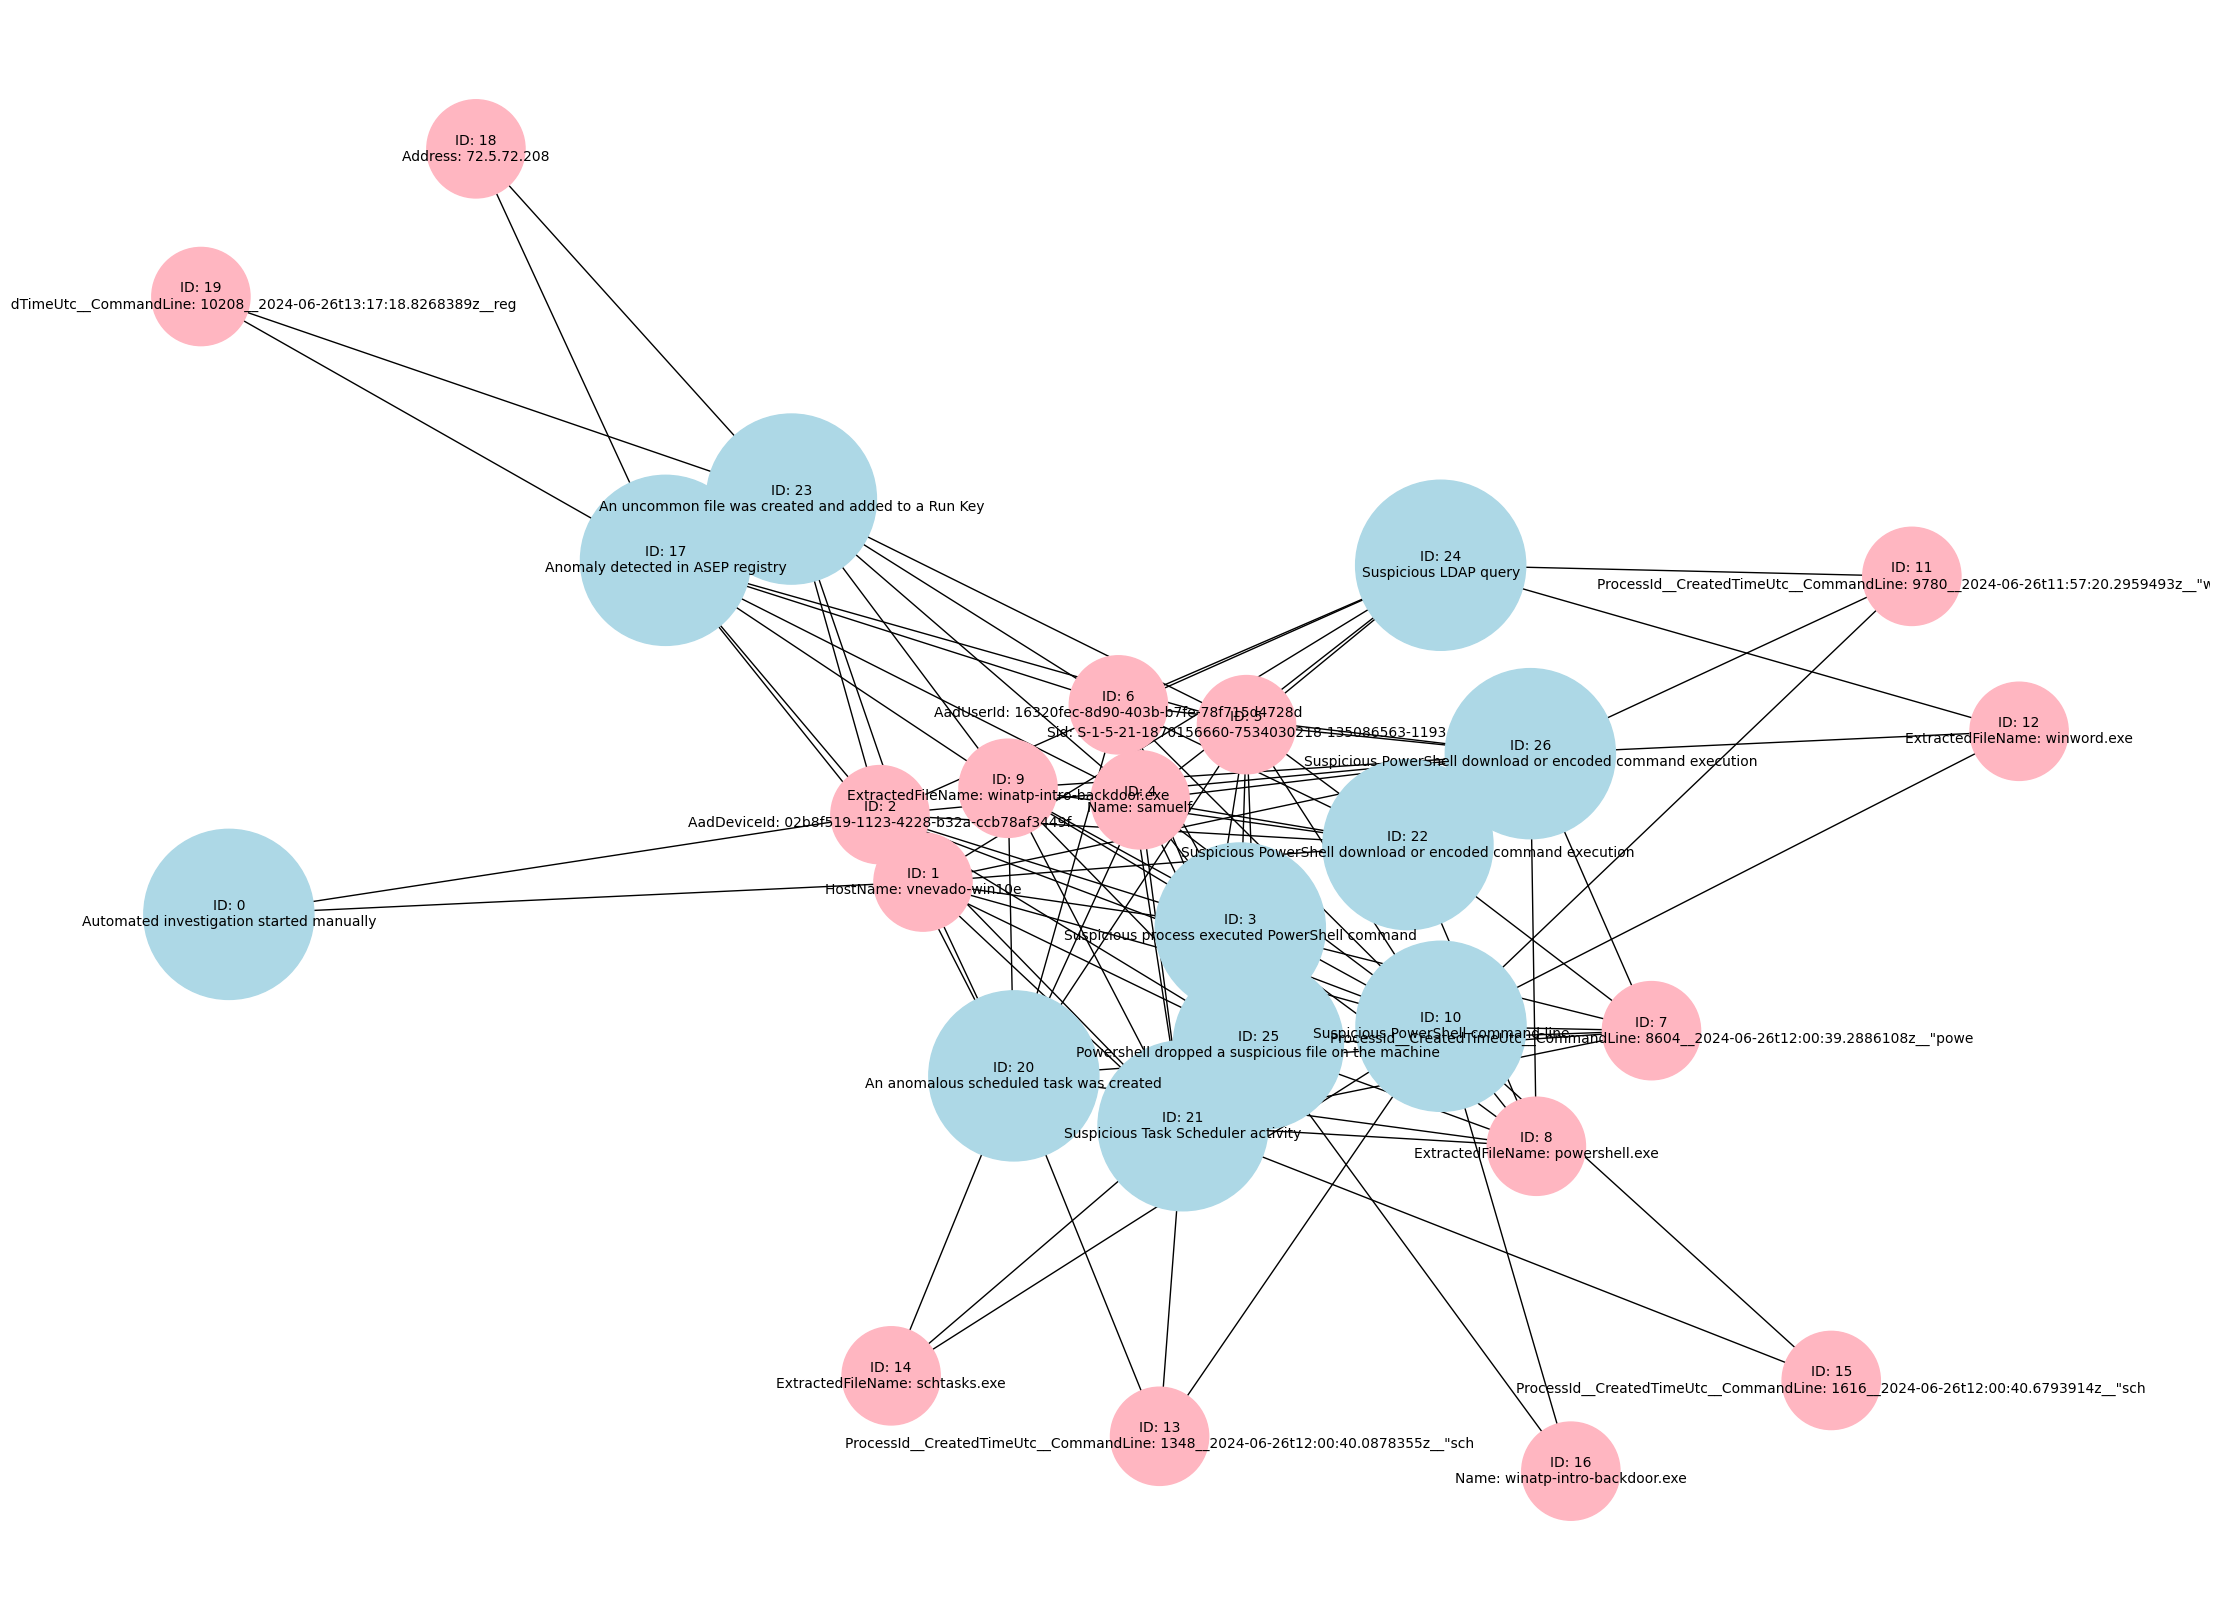

incident_166.graphml 30


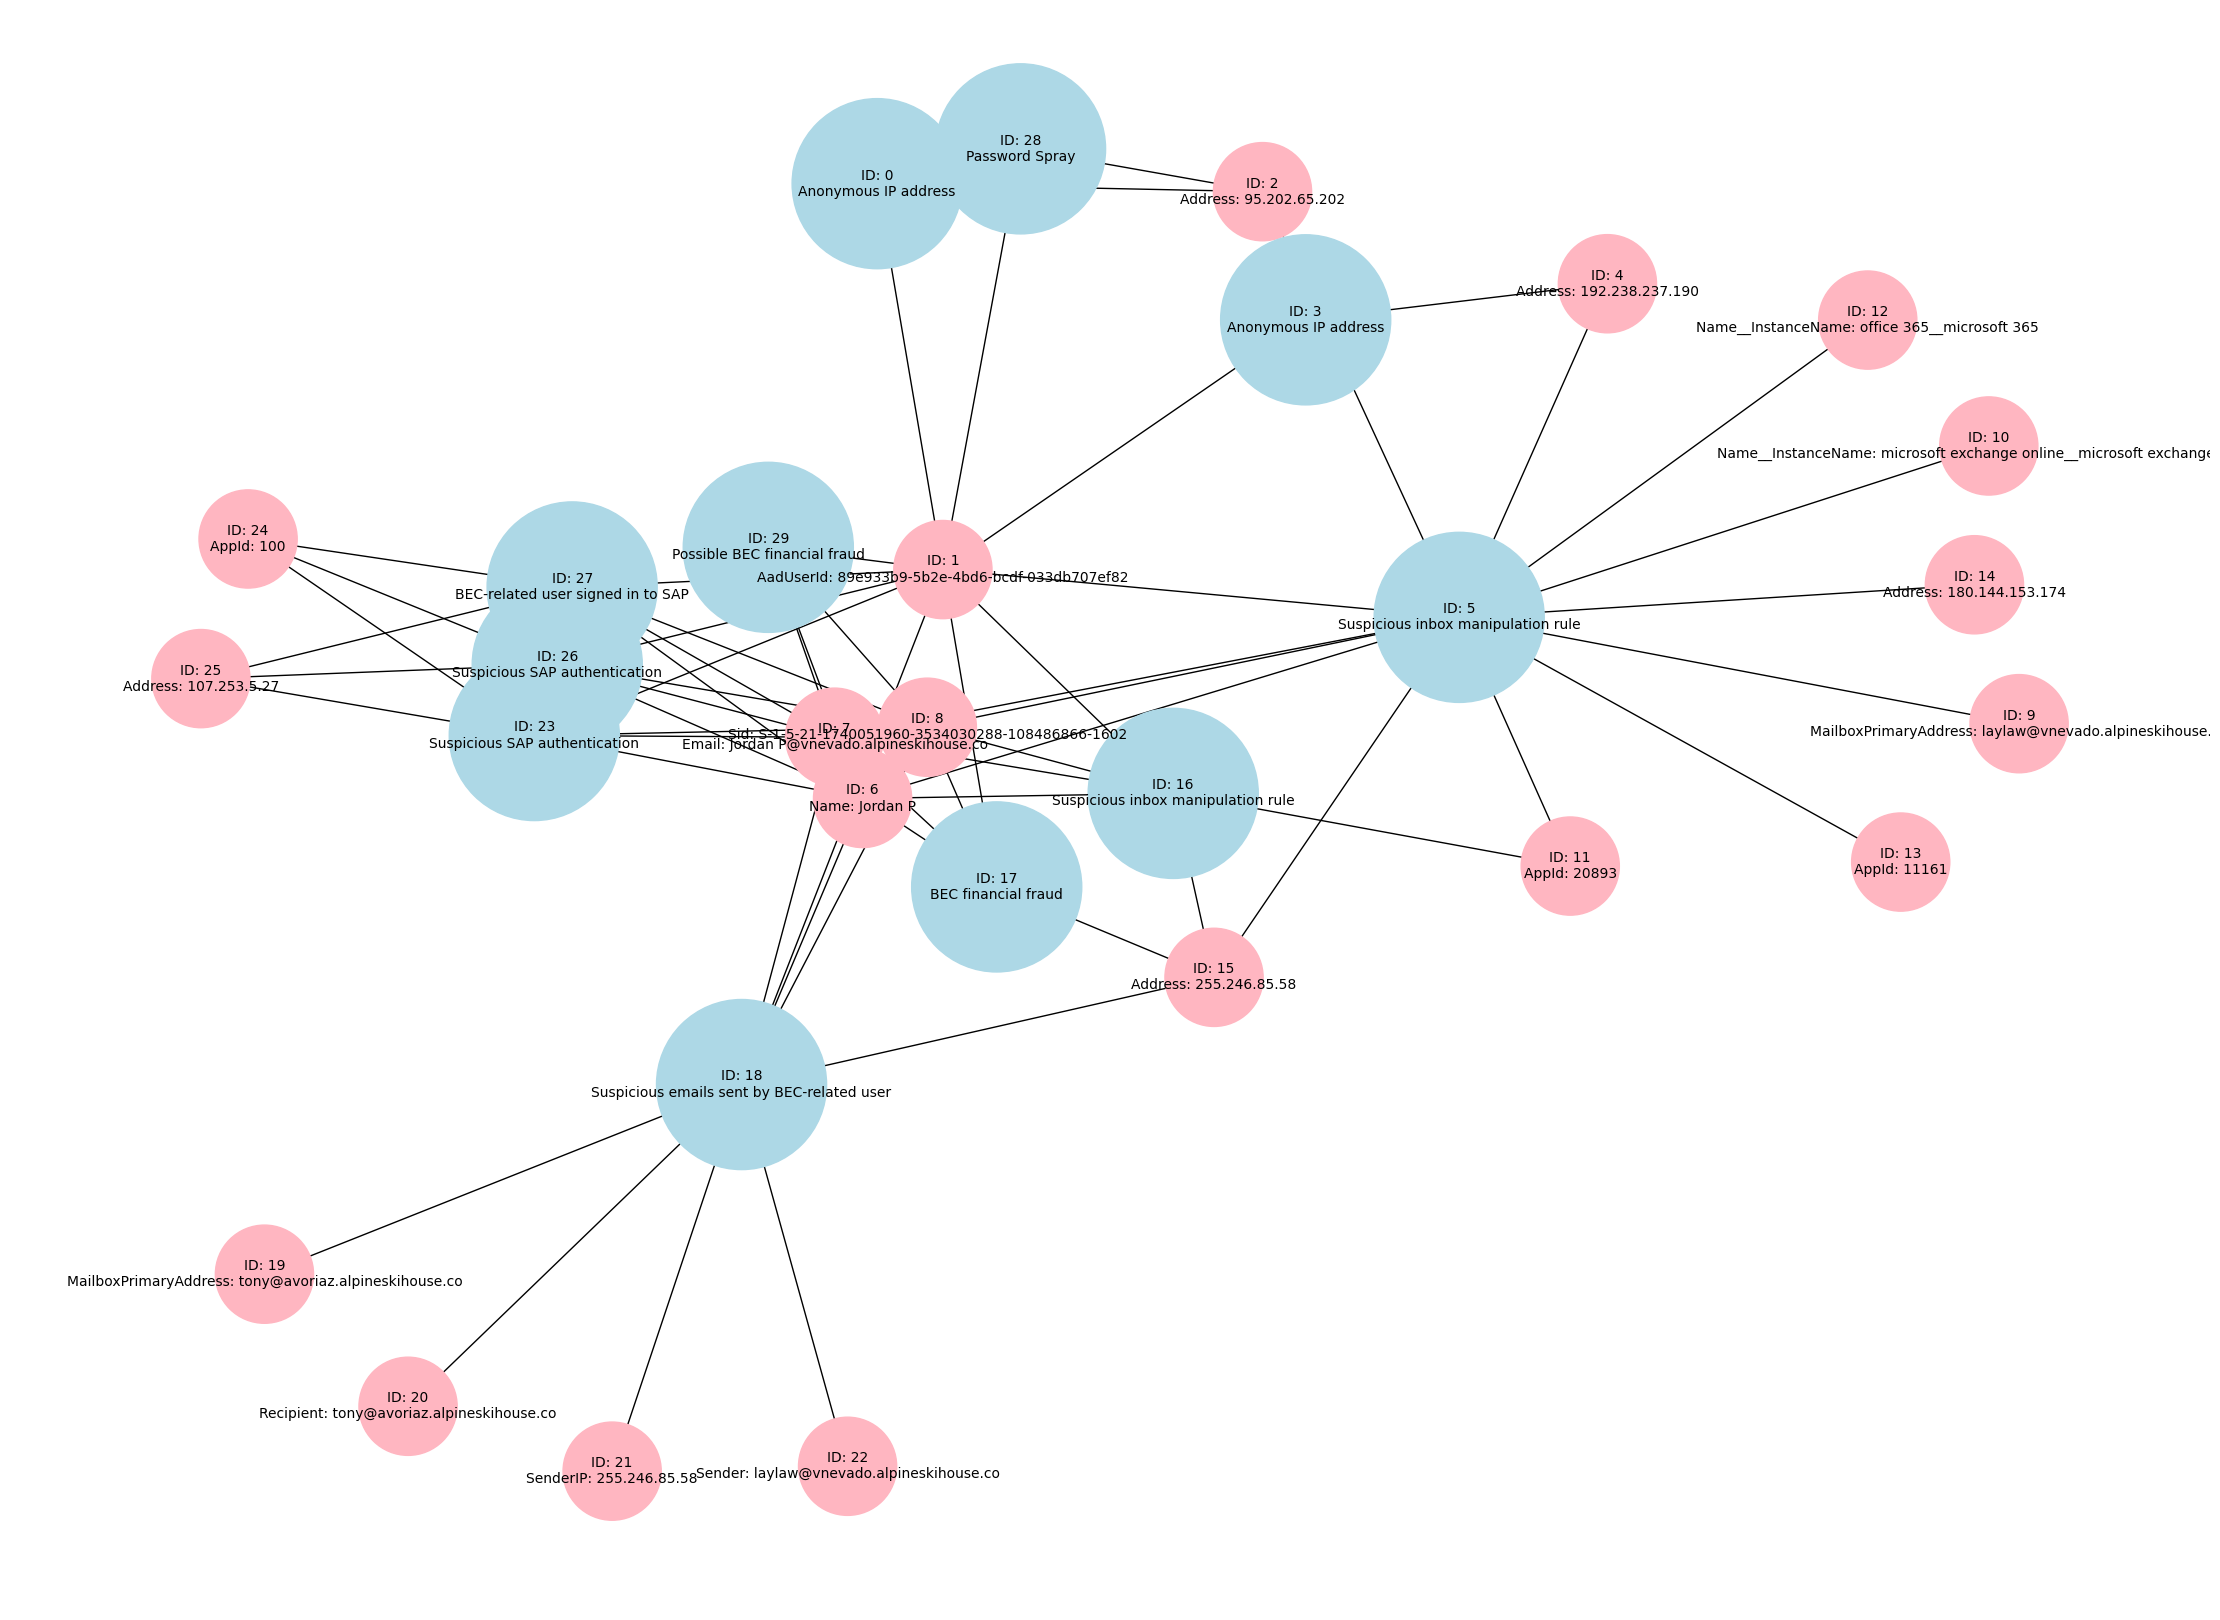

incident_55.graphml 110


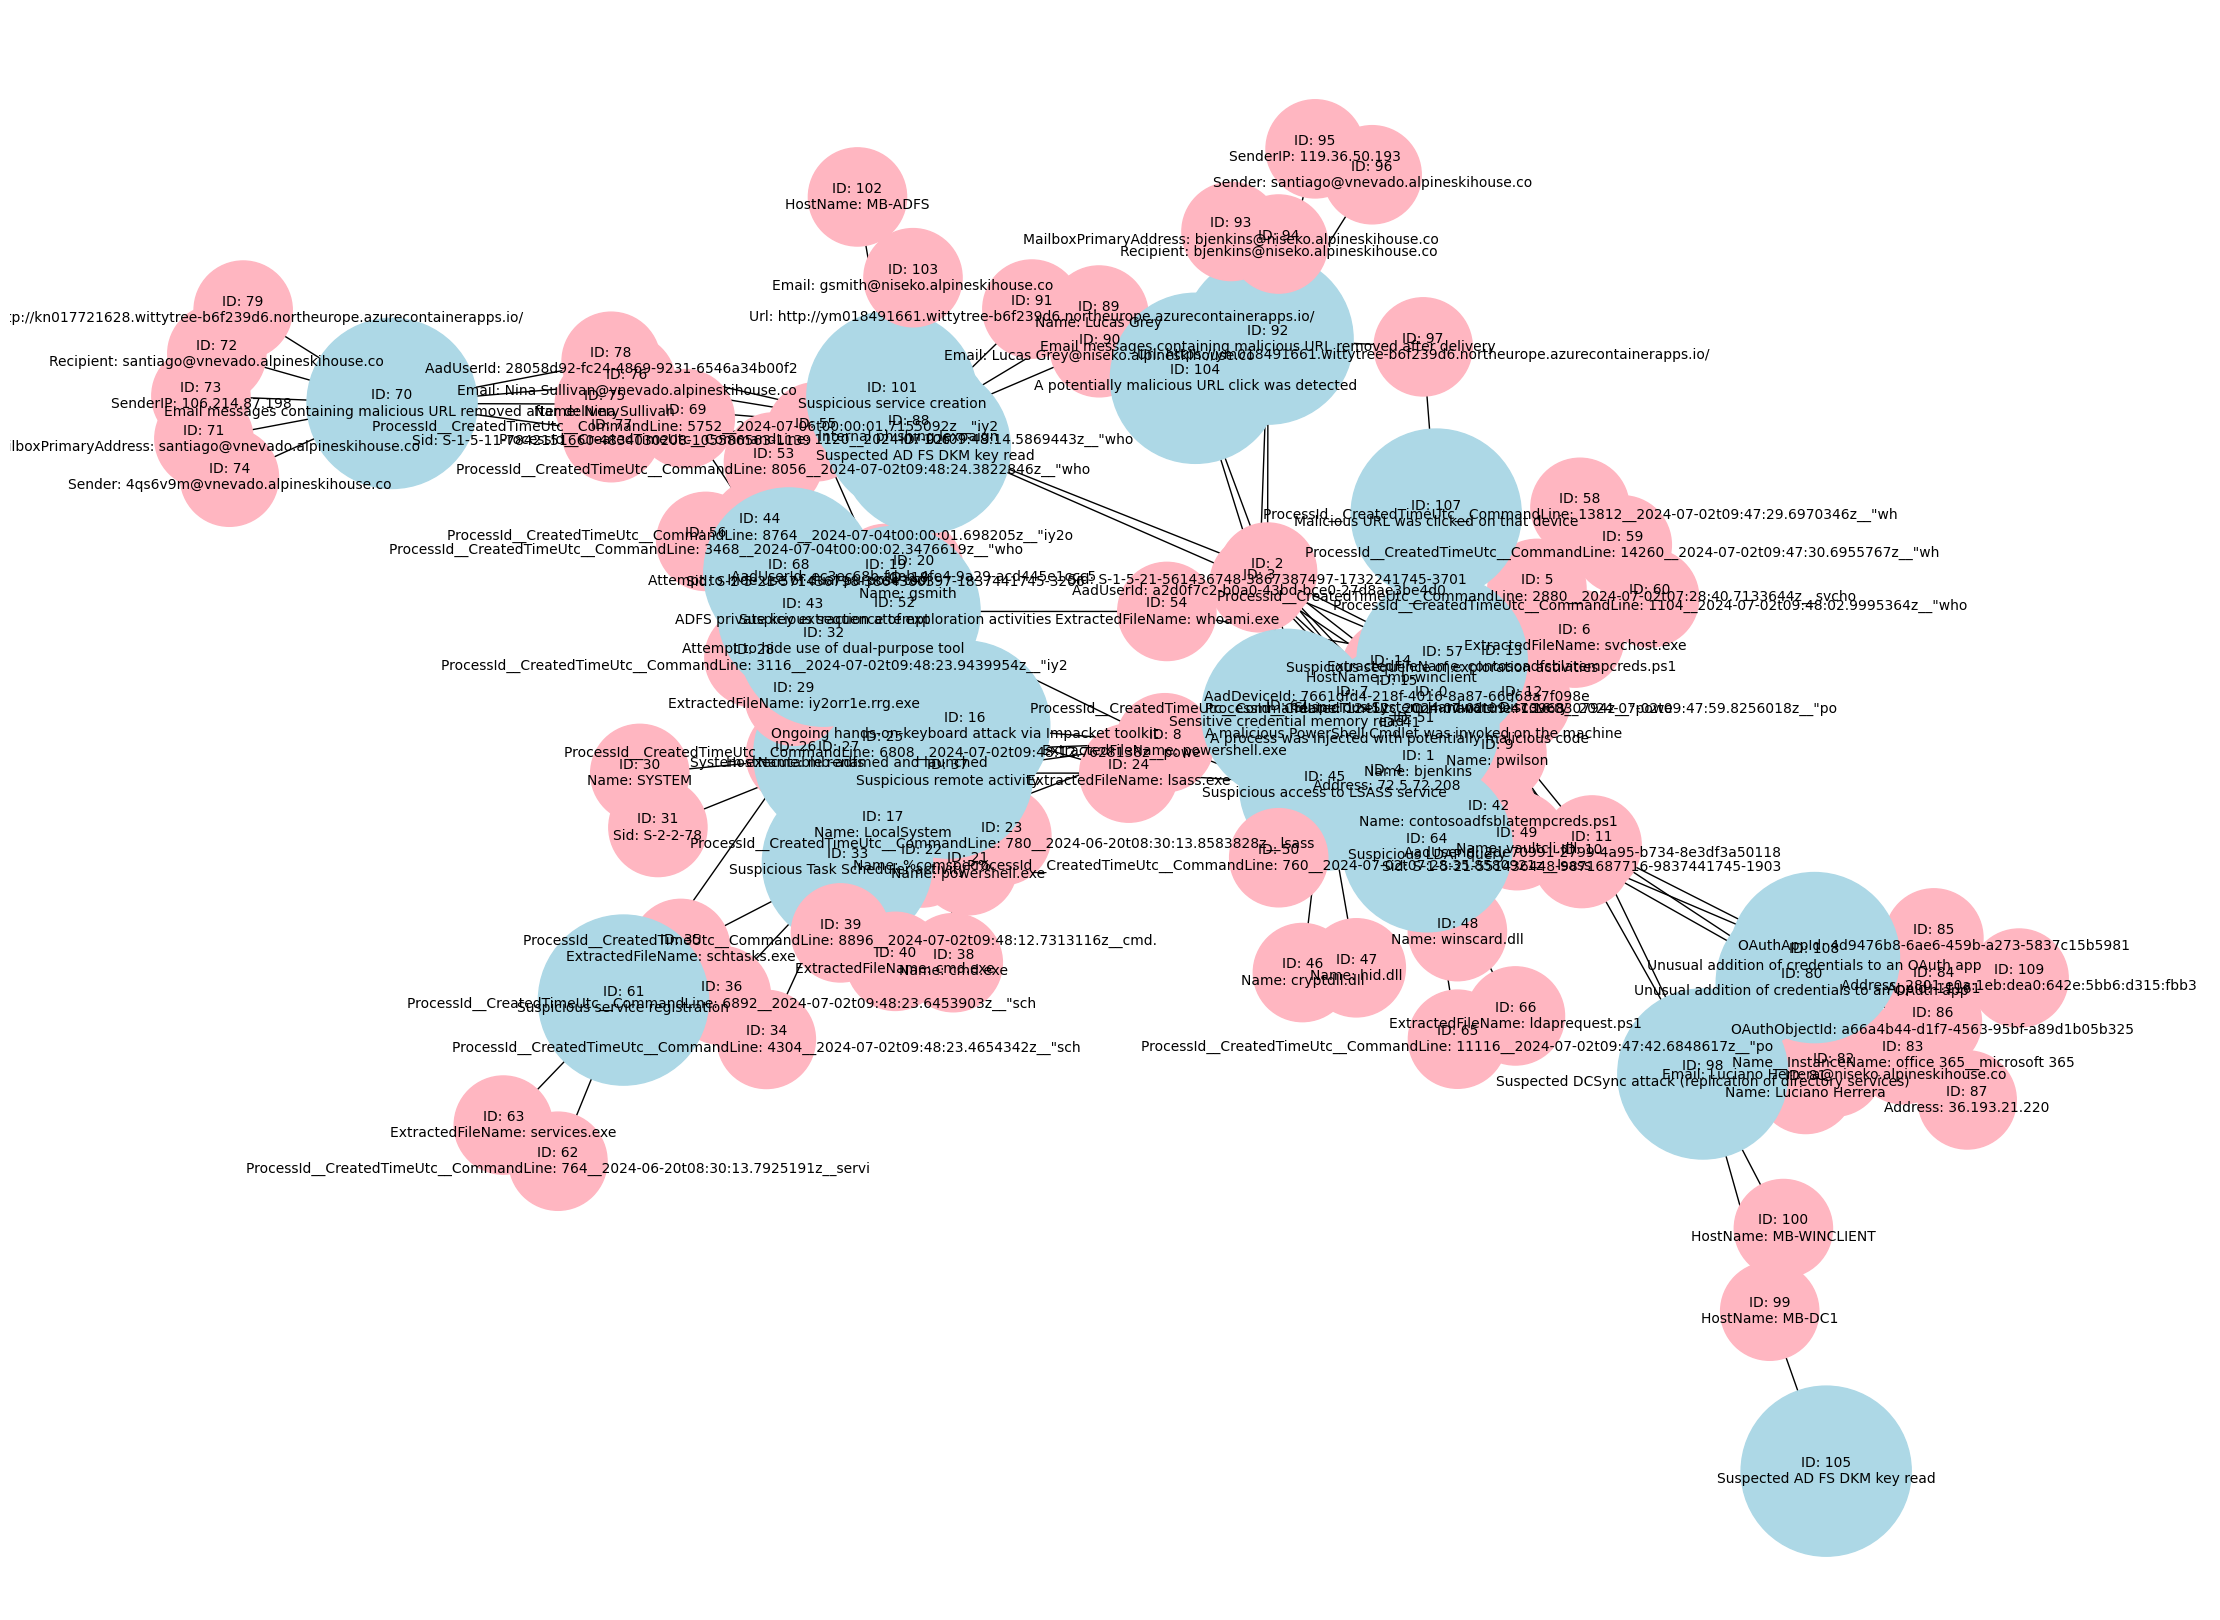

incident_5.graphml 169


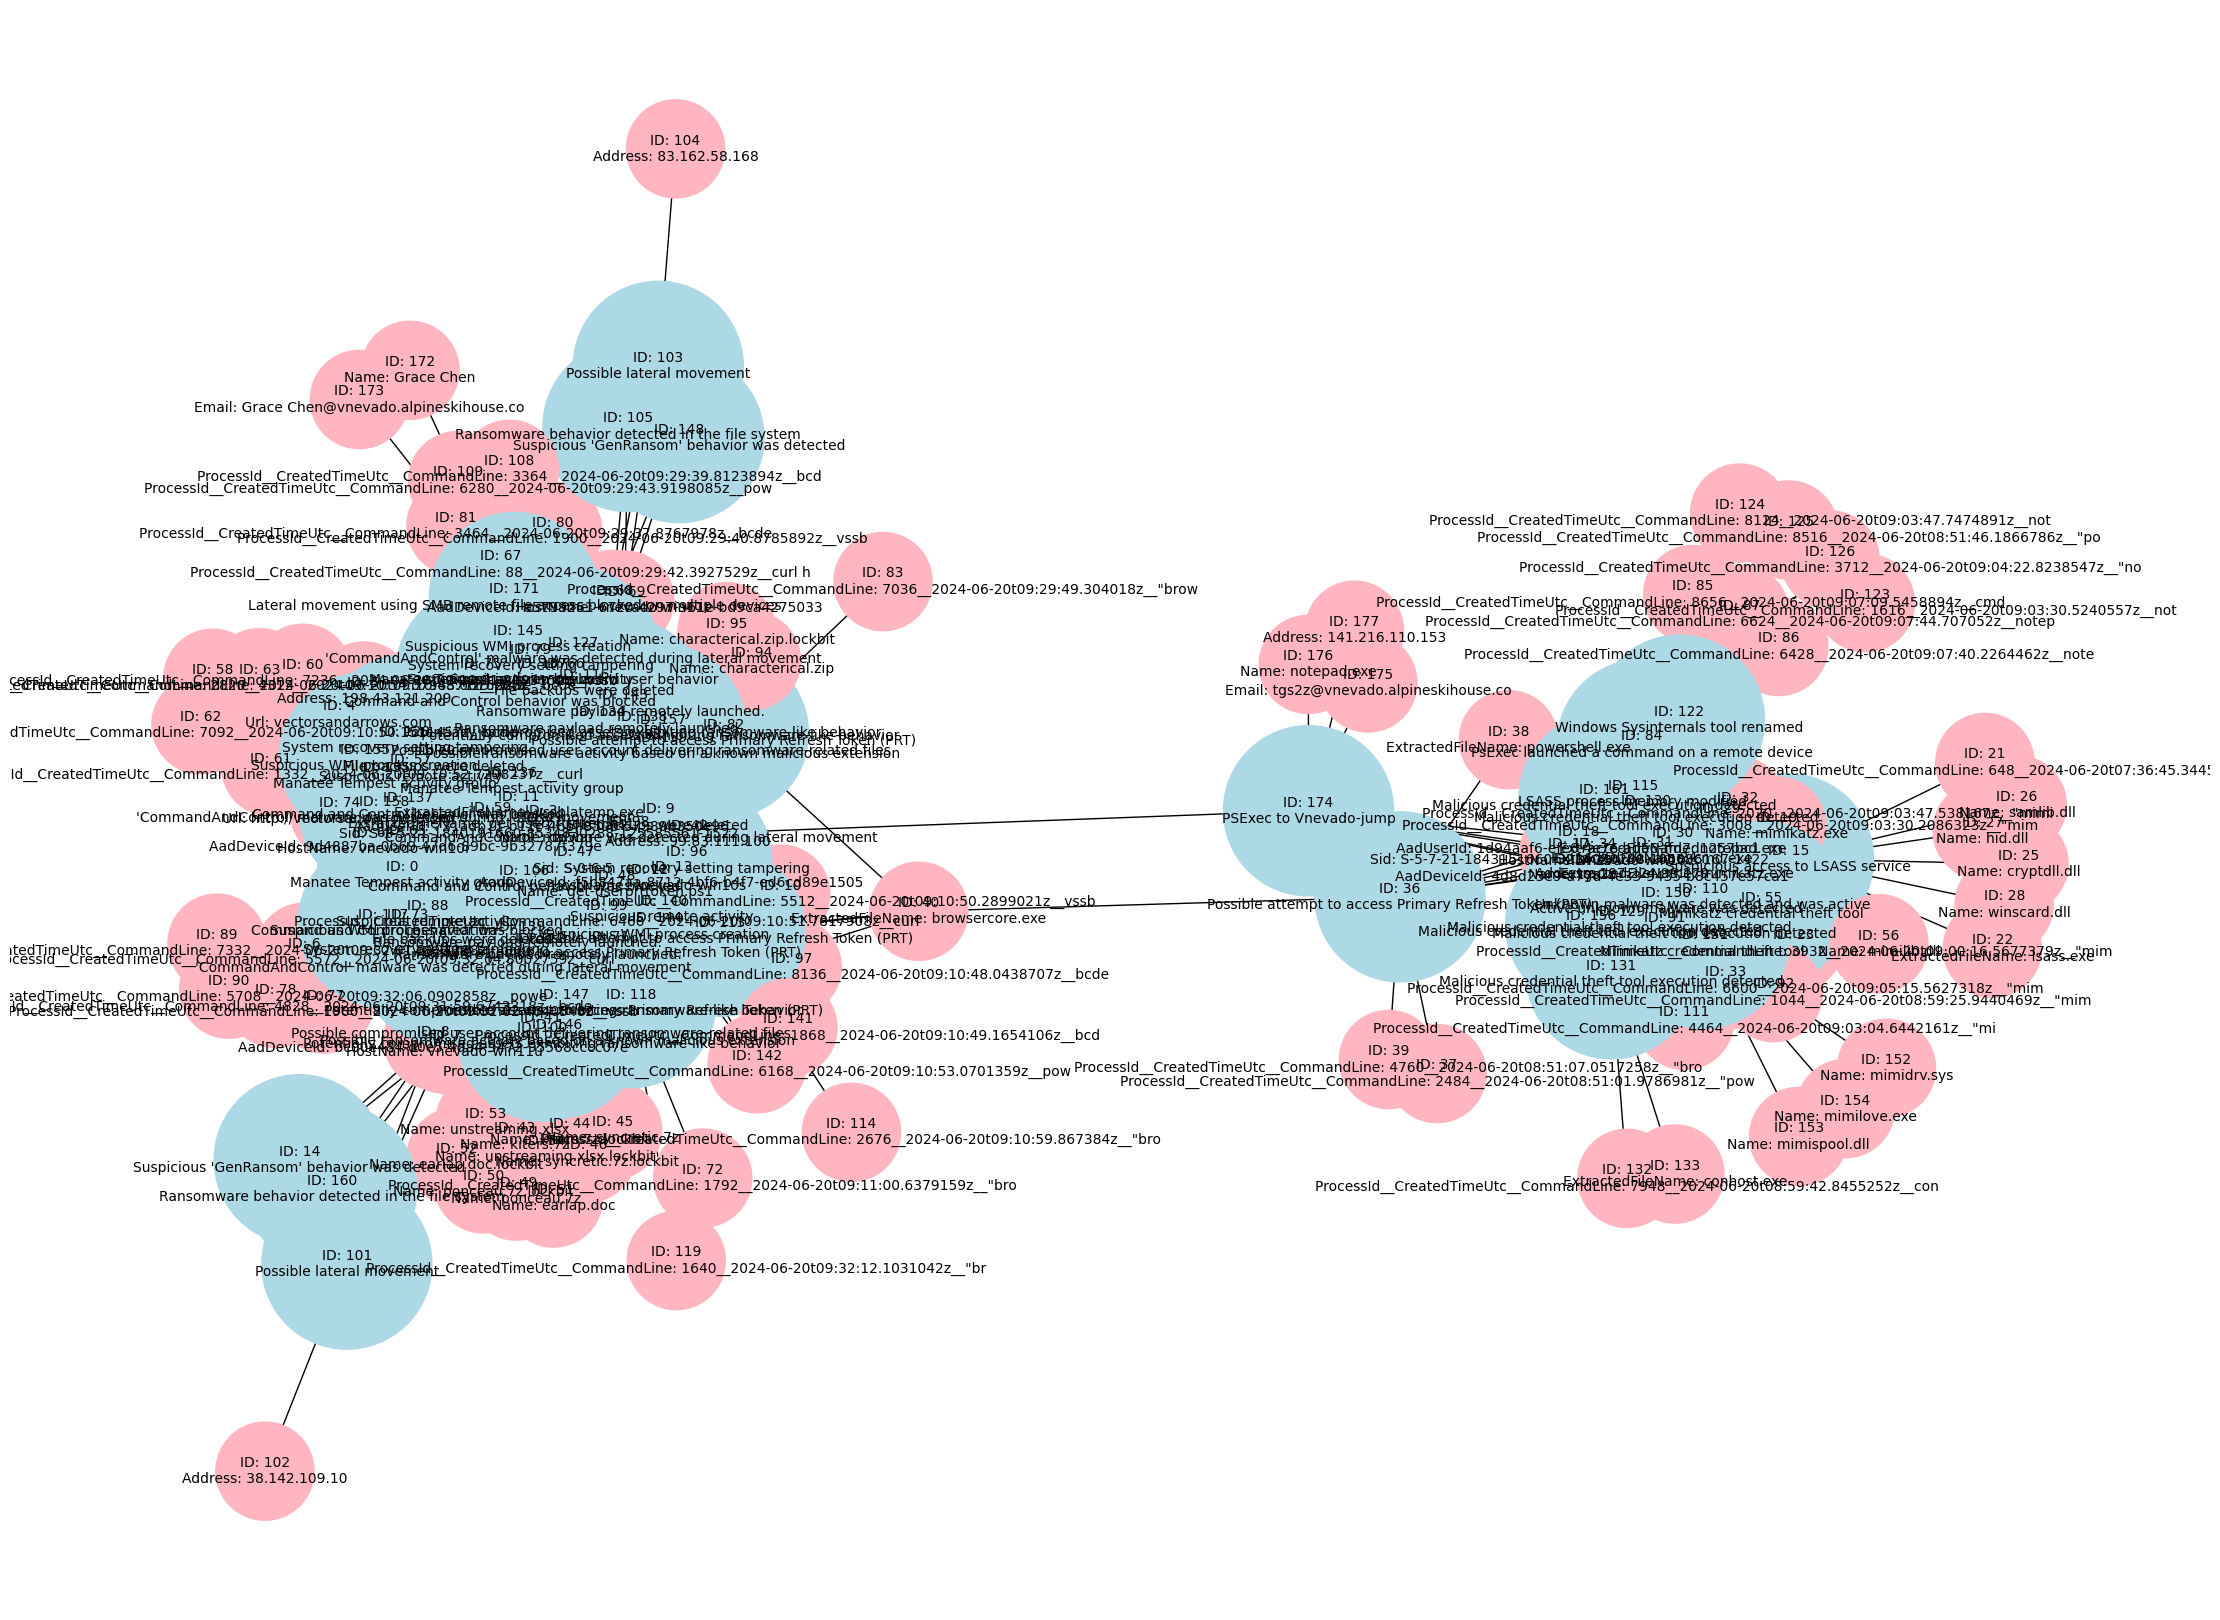

incident_38.graphml 17


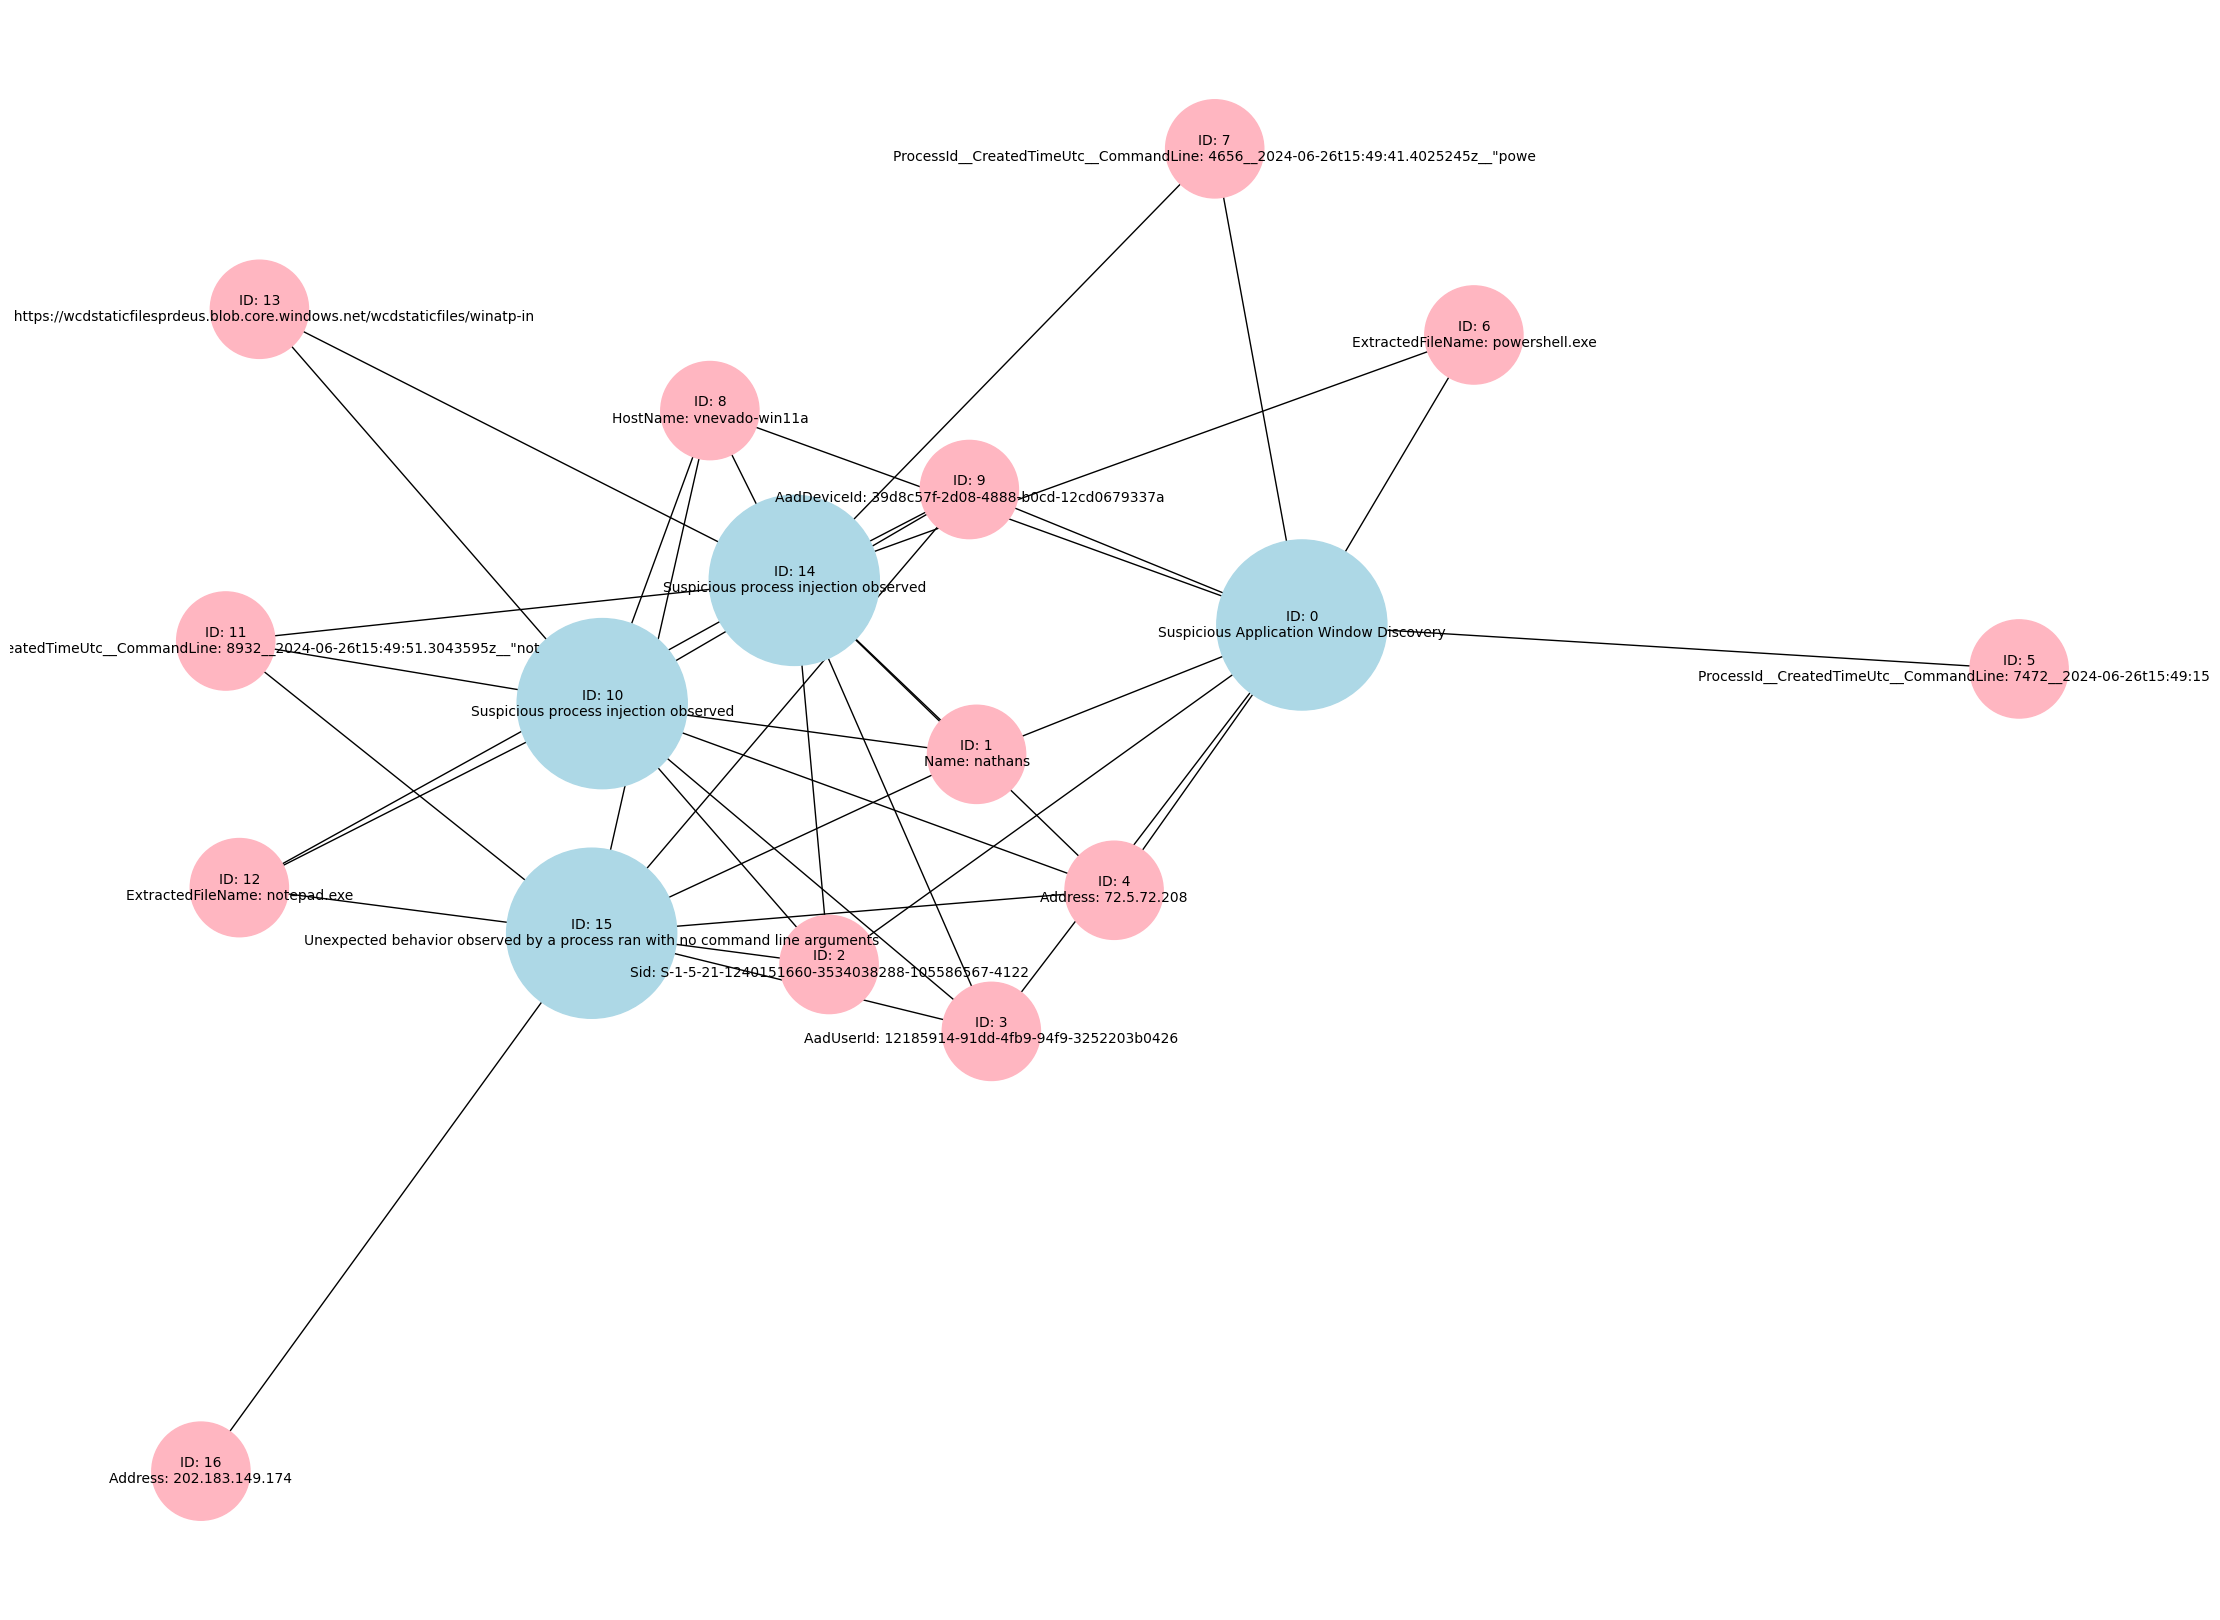

incident_134.graphml 26


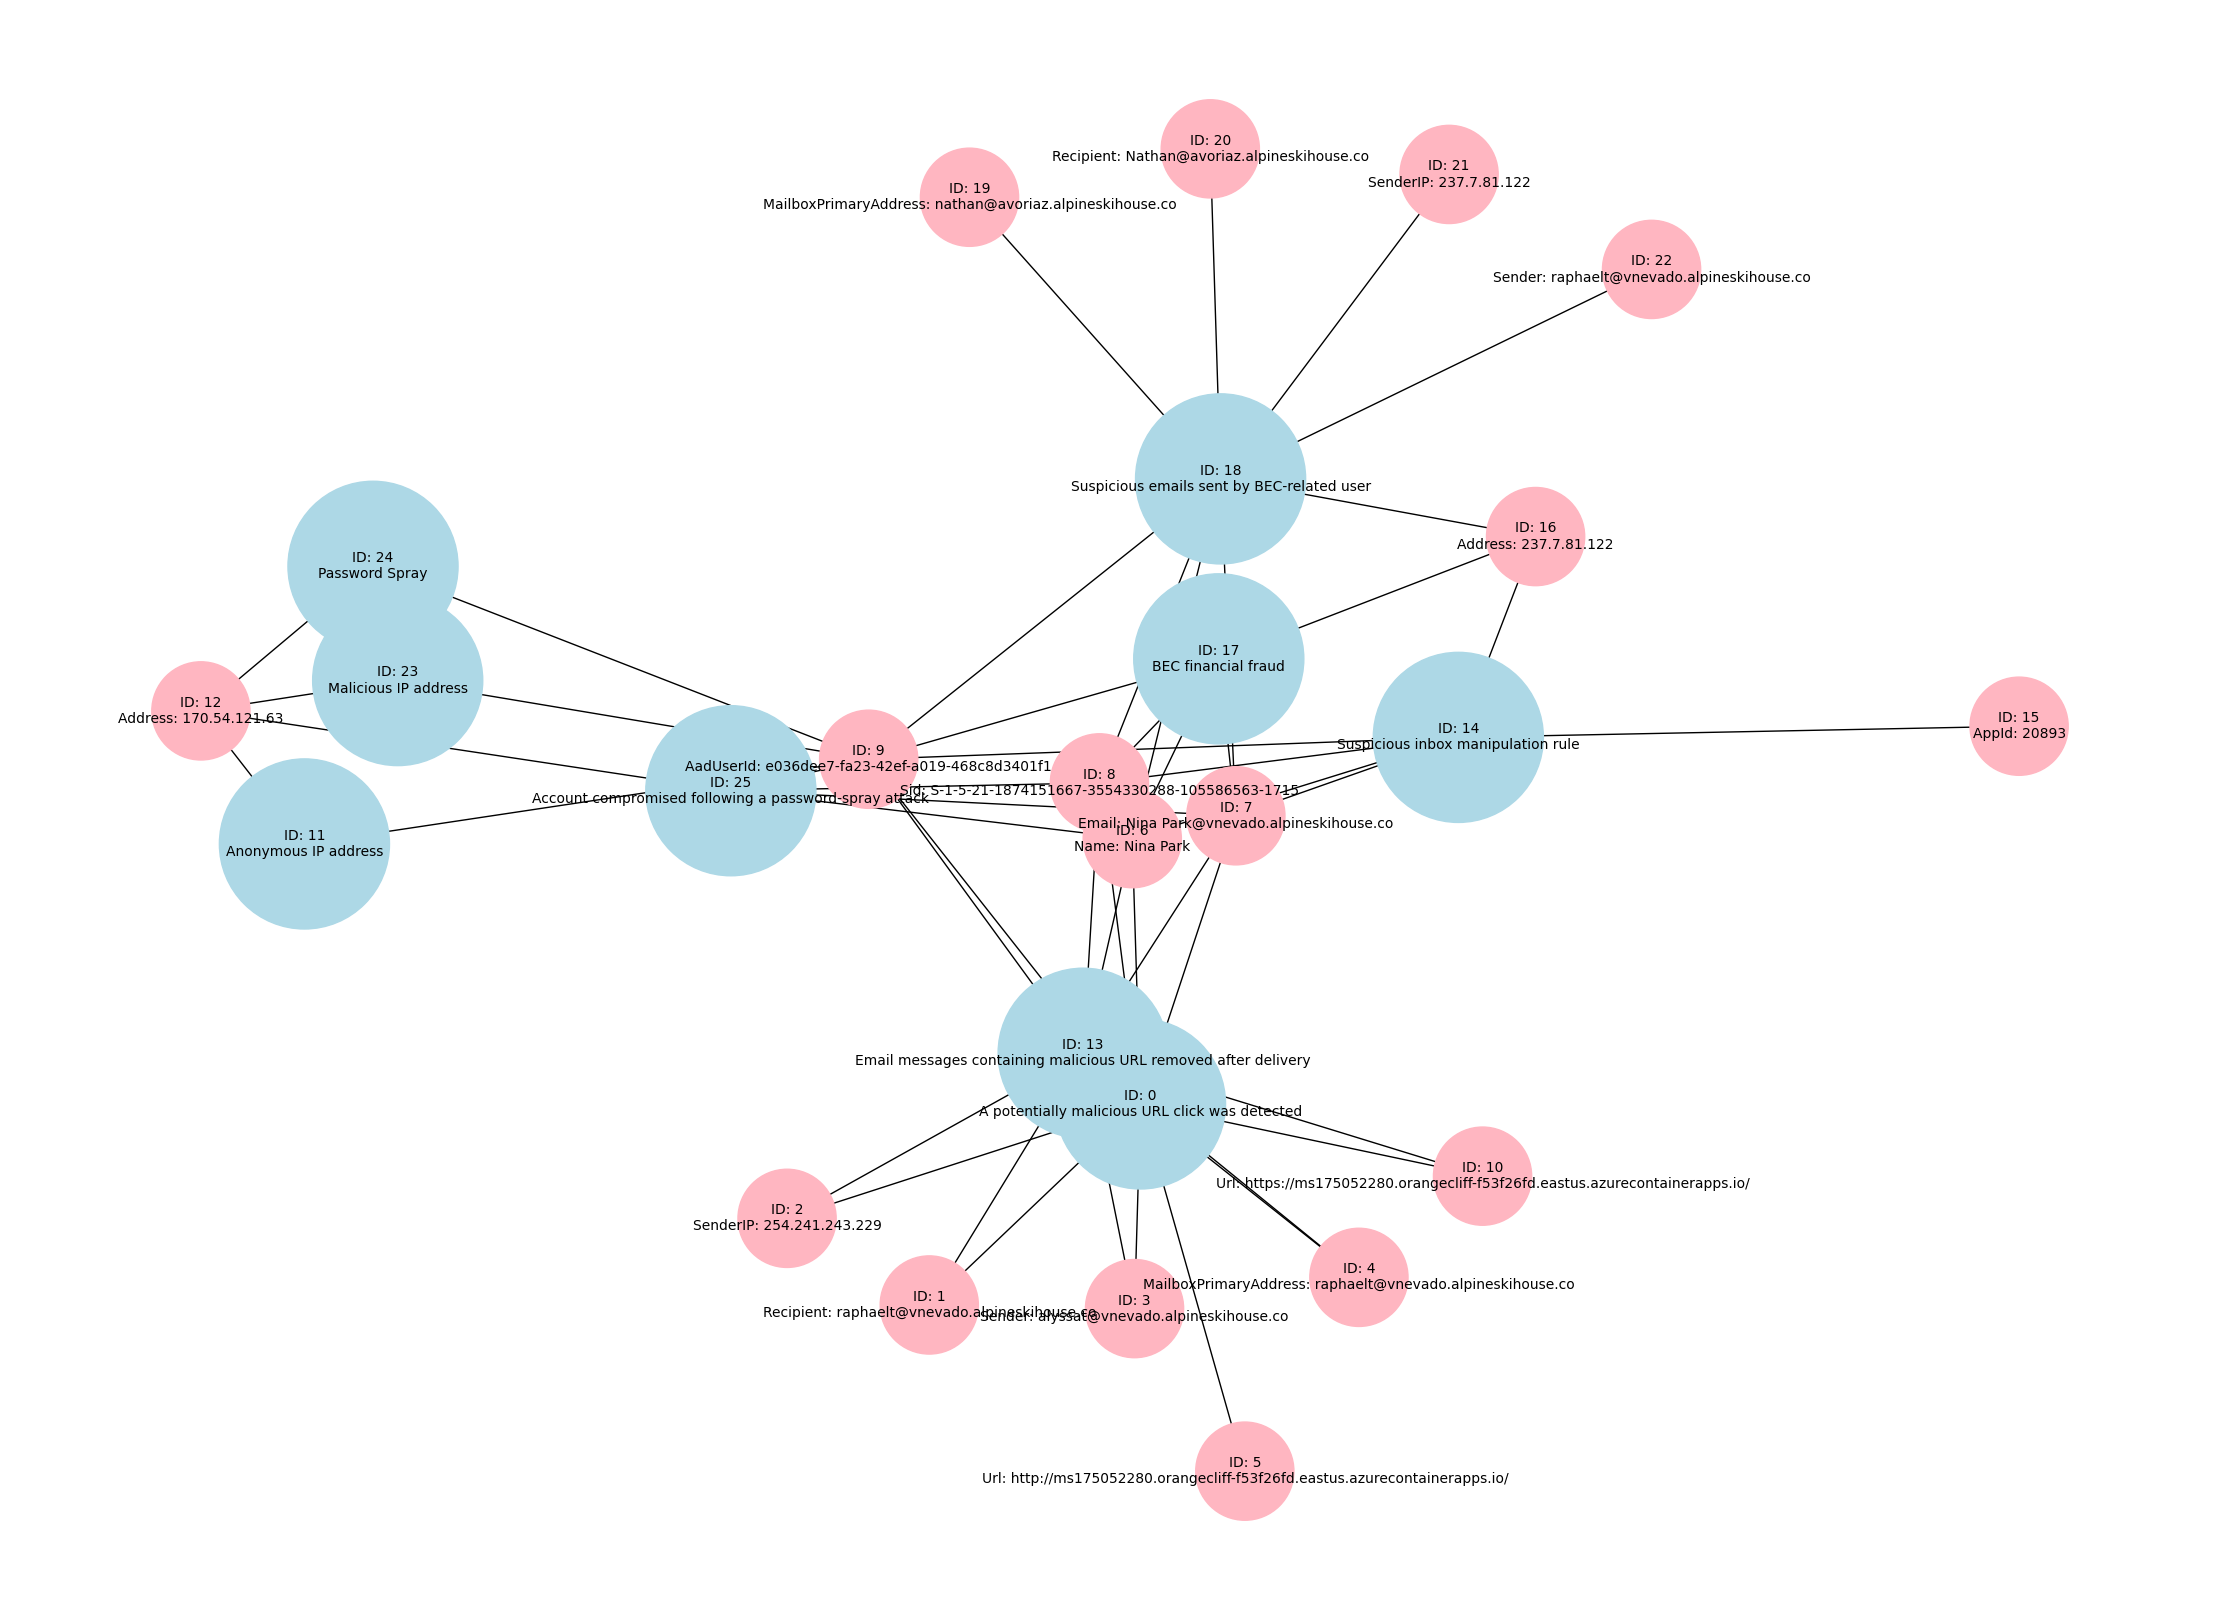

incident_39.graphml 137


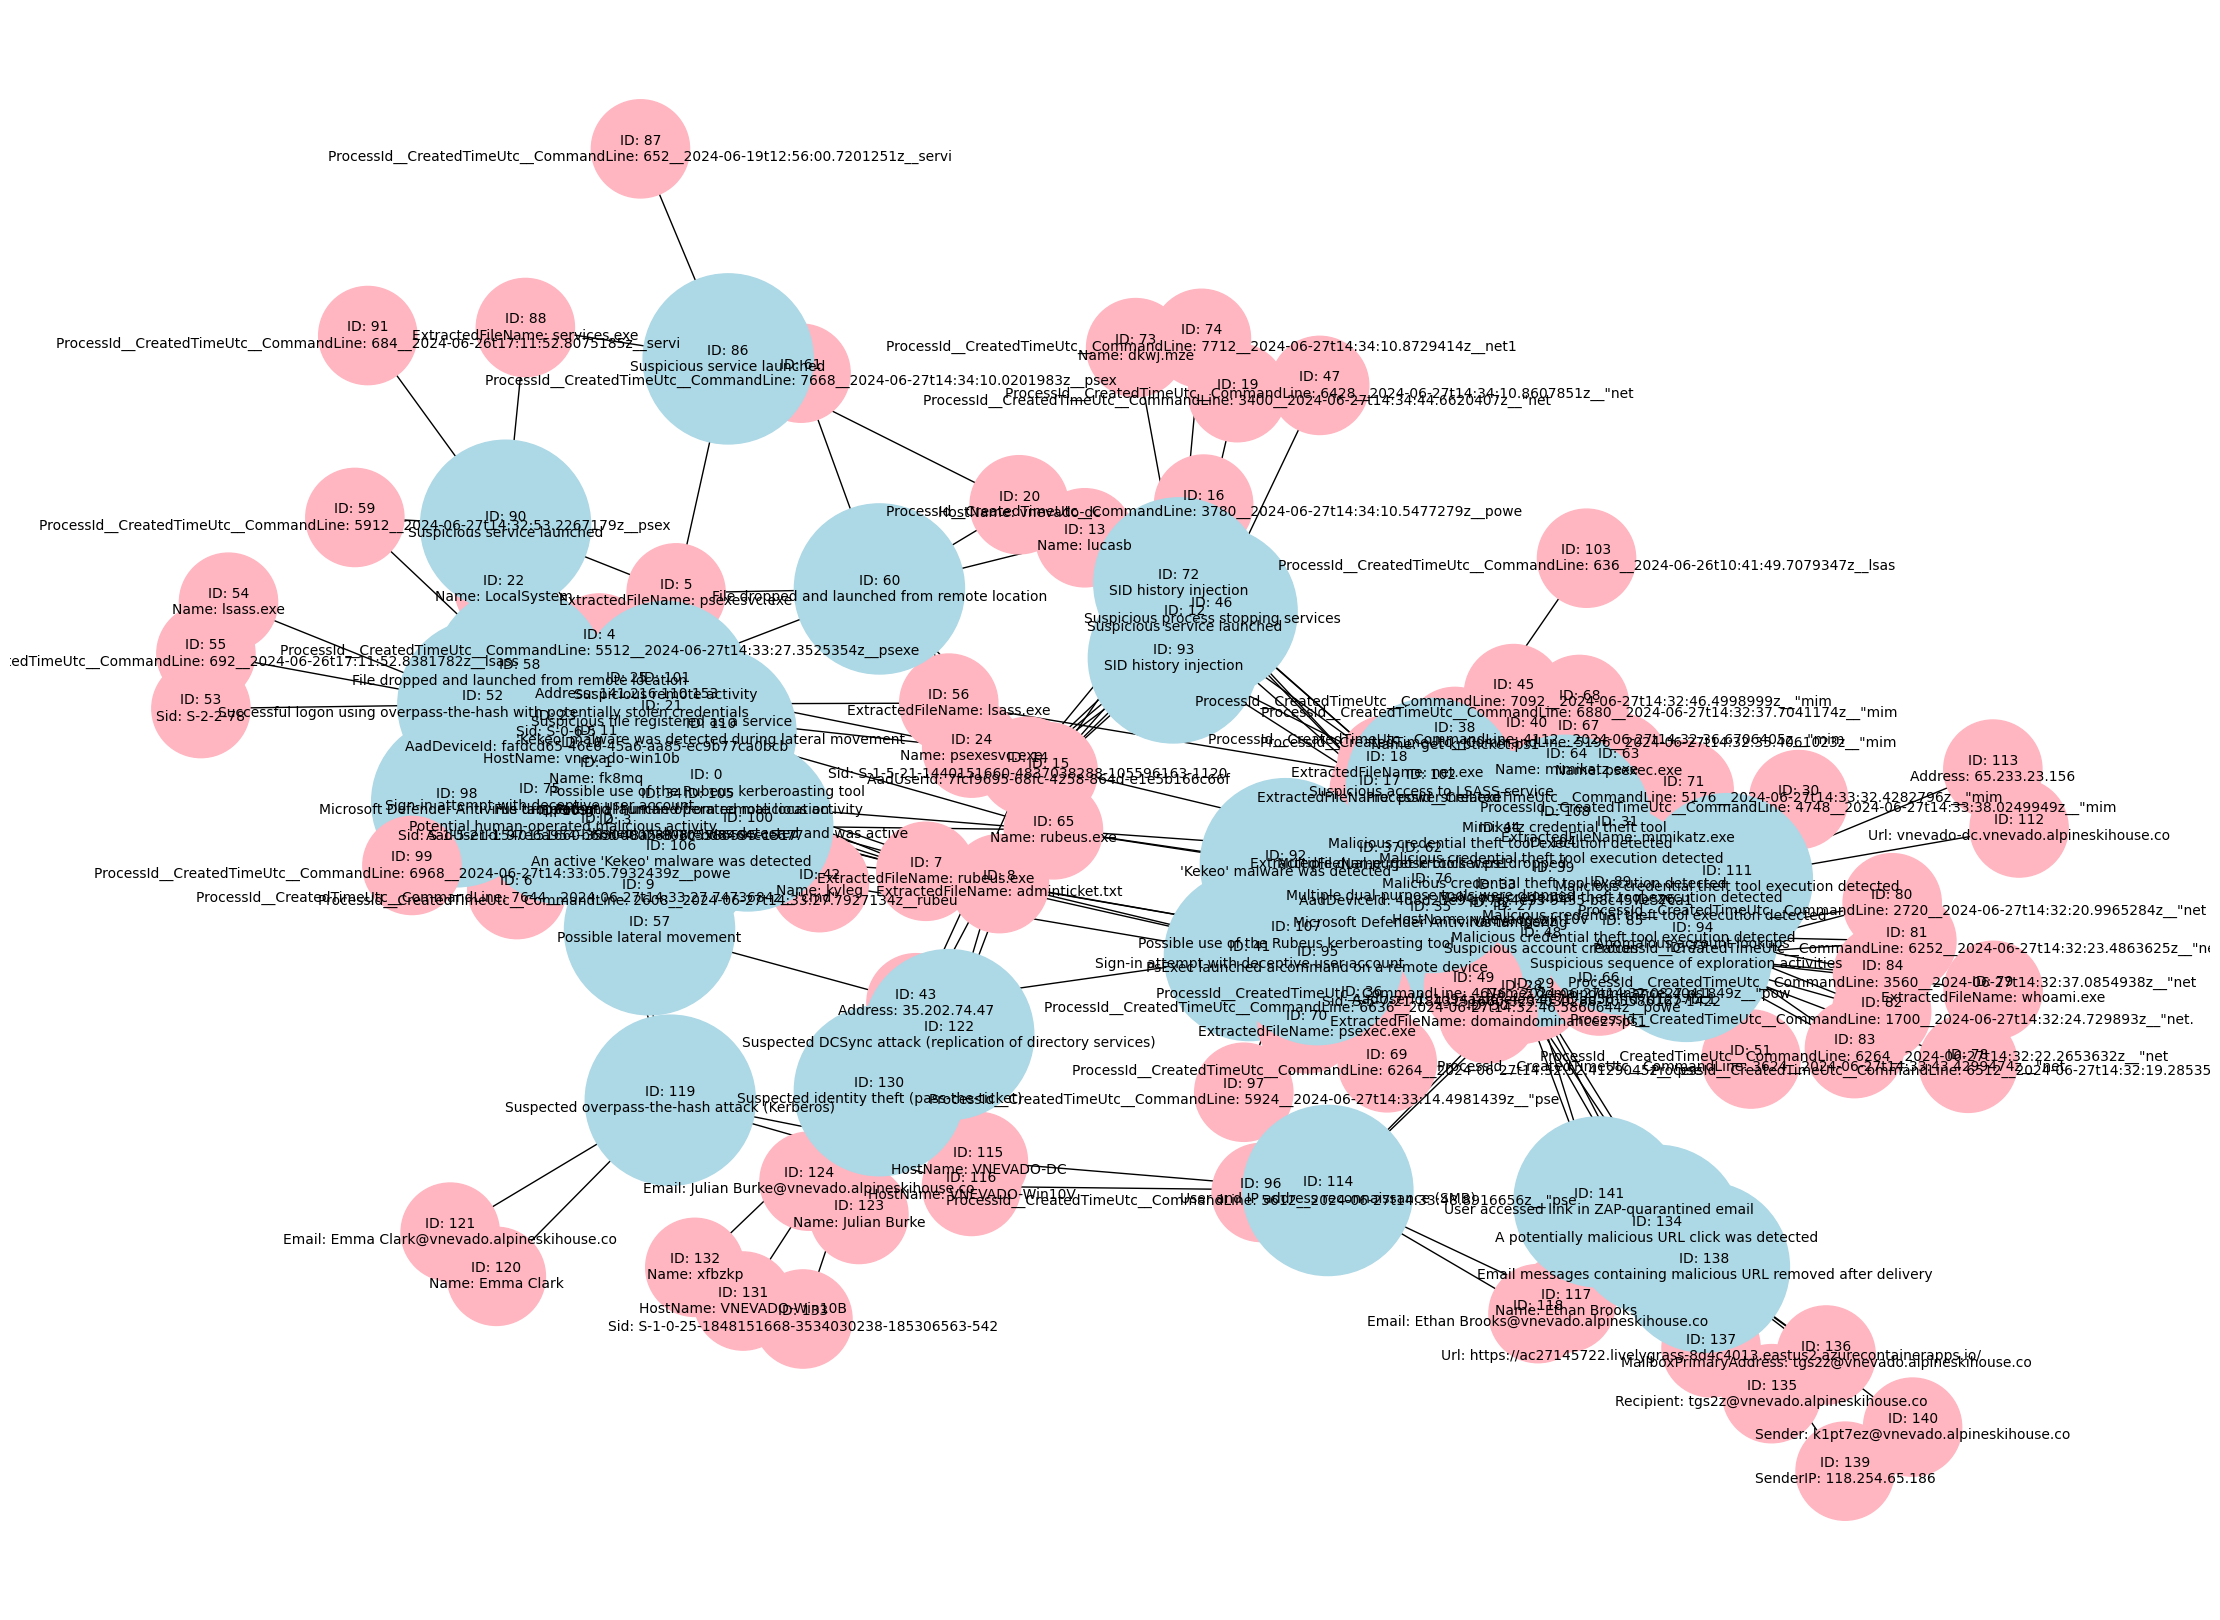

incident_322.graphml 38


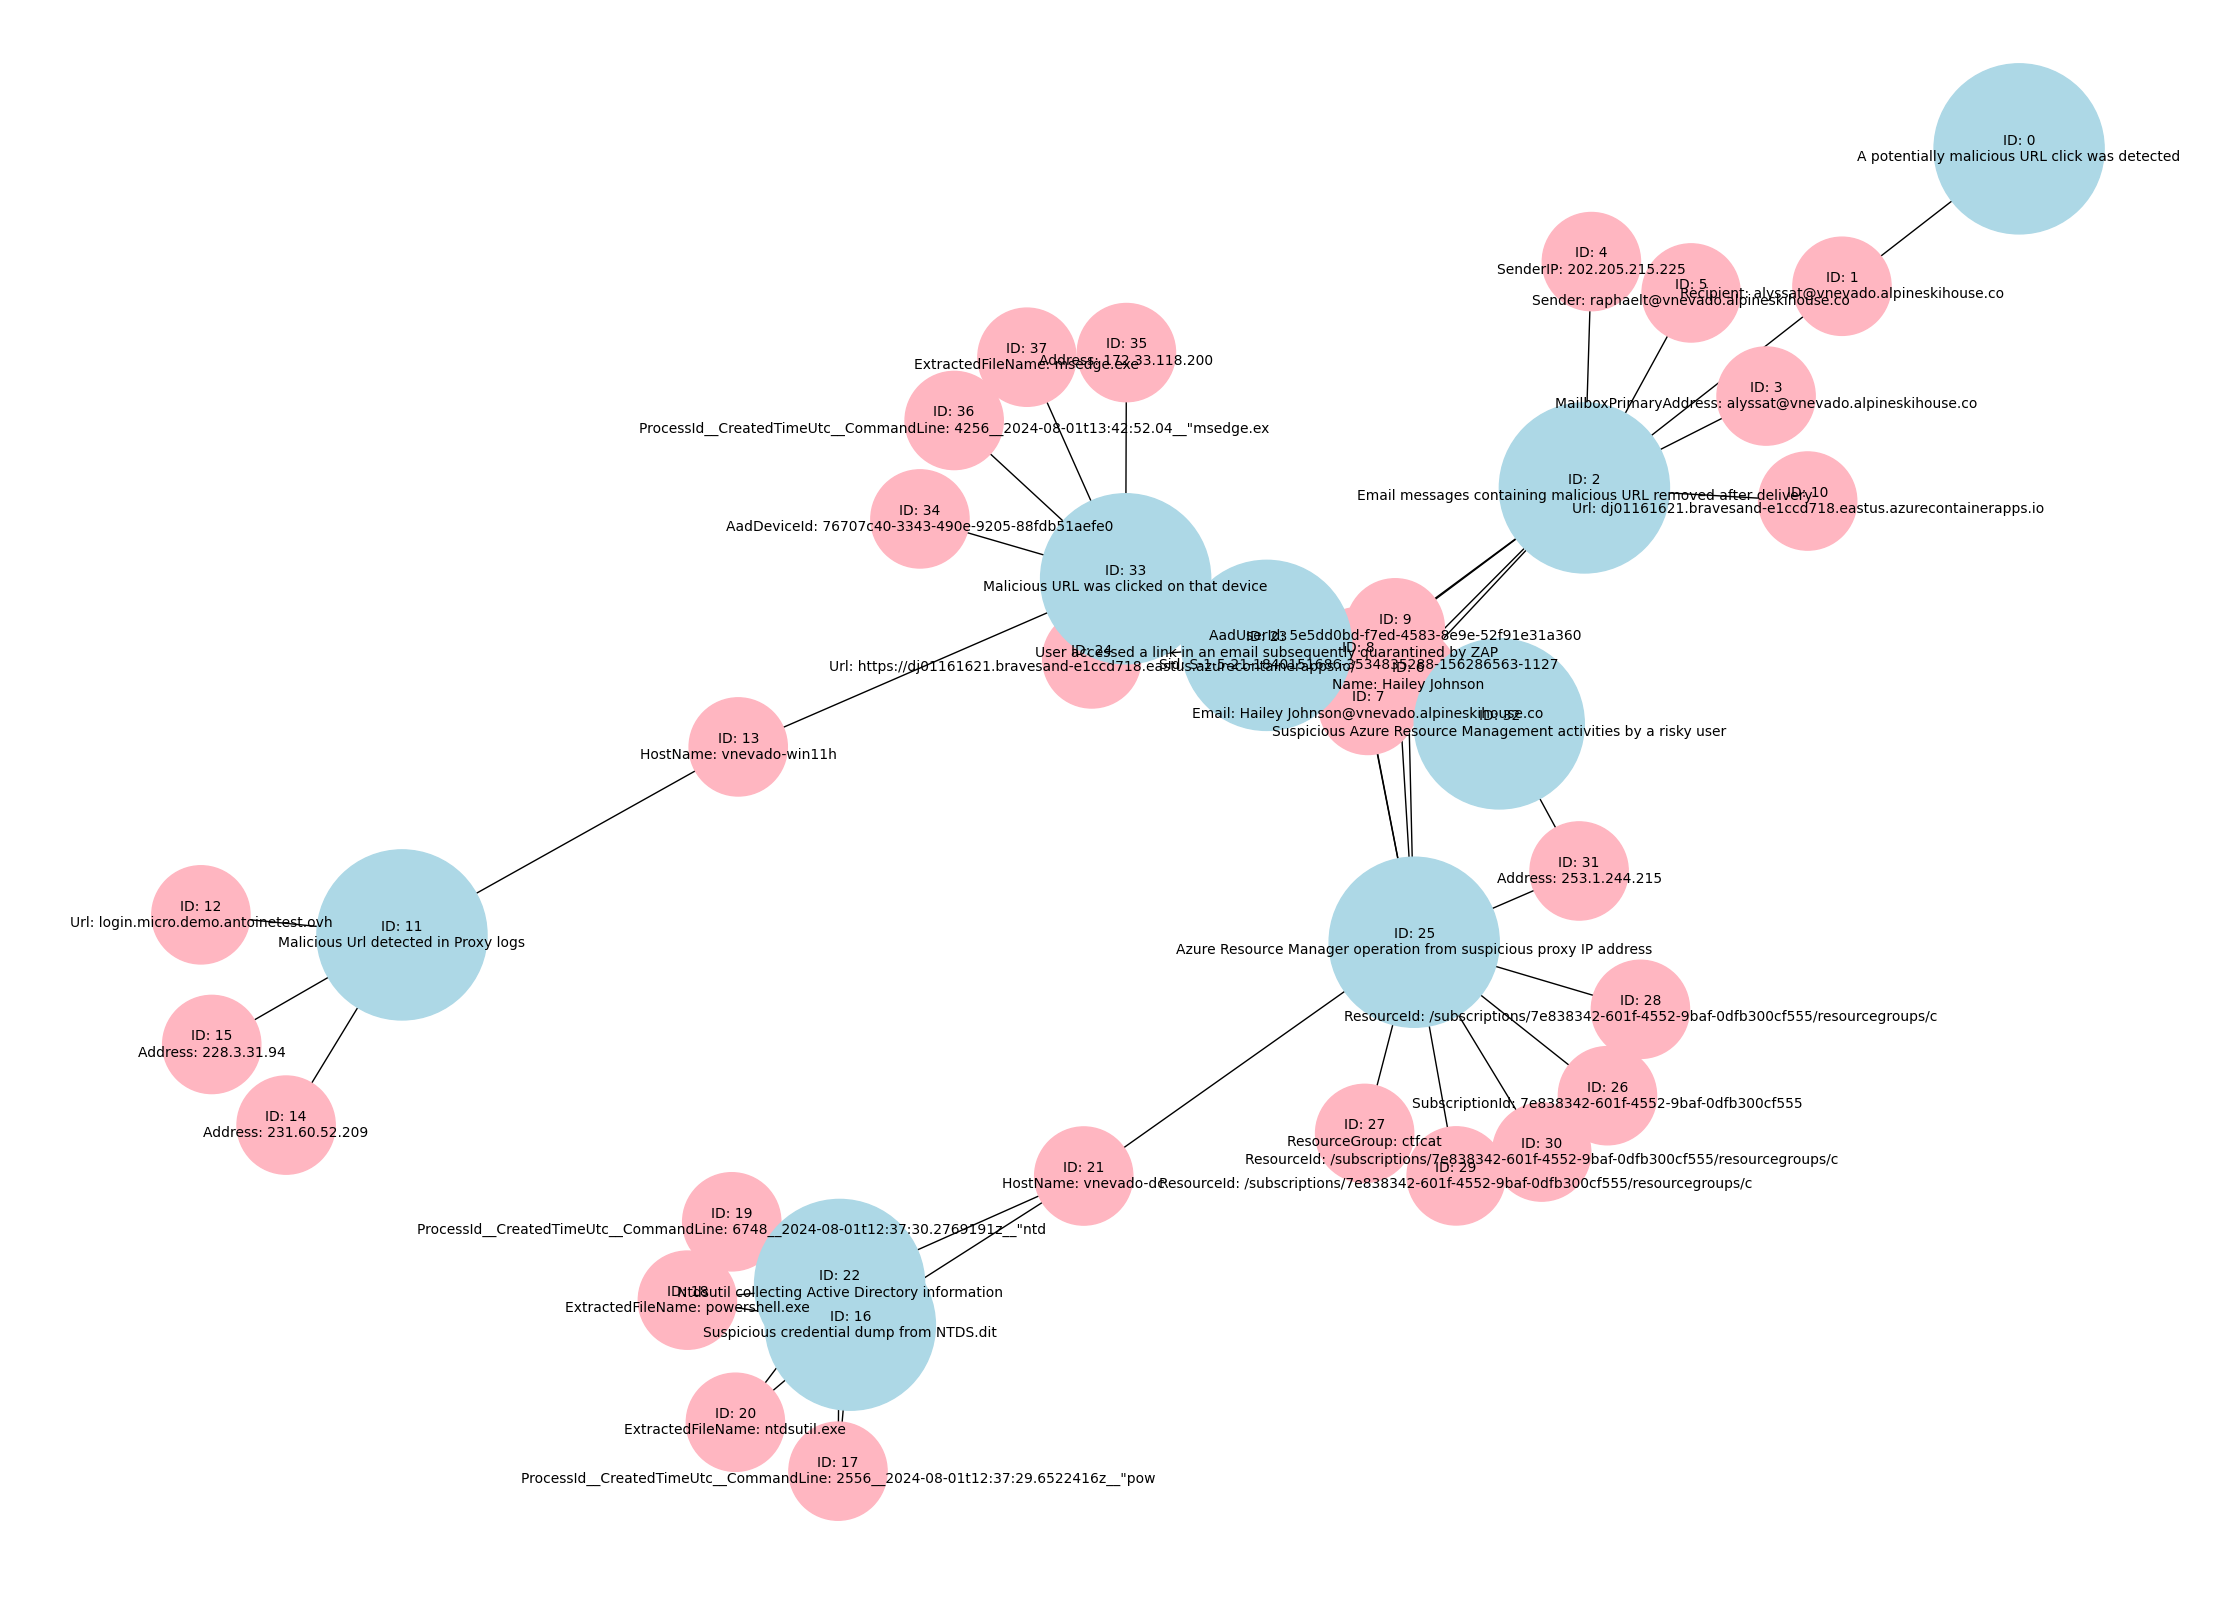

In [ ]:
from secgym.qagen.alert_graph import AlertGraph
import os

# iterate over folder

for filename in os.listdir("/Users/kevin/Downloads/SecRL/secgym/qagen/graph_files"):
    if filename.endswith(".graphml"):
        alert_graph = AlertGraph()
        alert_graph.load_graph_from_graphml(filepath=f"./graph_files/{filename}")
        print(filename, len(alert_graph.graph.nodes))
        alert_graph.plot_custom_graph()


In [14]:
from secgym.qagen.alert_graph import AlertGraph
import os

# iterate over folder
files = os.listdir("./graph_files")
files

['incident_34.graphml',
 'incident_166.graphml',
 'incident_55.graphml',
 'incident_5.graphml',
 'incident_38.graphml',
 'incident_134.graphml',
 'incident_39.graphml',
 'incident_322.graphml']

In [15]:
import networkx as nx
from secgym.qagen.alert_graph import AlertGraph
import os

# get max distance between any two nodes

problem_count = {
    1: 0,
}

for filename in os.listdir("/Users/kevin/Downloads/SecRL/secgym/qagen/graph_files"):
    if filename.endswith(".graphml"):
        print(filename)
        alert_graph = AlertGraph()
        alert_graph.load_graph_from_graphml(filepath=f"./graph_files/{filename}")
        # alert_graph.plot_custom_graph()

        all_paths = alert_graph.get_alert_paths(k=1, verbose=False)
        for a in all_paths:
            hop = len(a['shortest_alert_path'])//2 + 1
            if hop in problem_count:
                problem_count[hop] += 1
            else:
                problem_count[hop] = 1

        print("-------------------")
        # max_distance = 0
        # for node in alert_graph.graph.nodes:
        #     for other_node in alert_graph.graph.nodes:
        #         if node != other_node:
        #             try:
        #                 distance = nx.shortest_path_length(alert_graph.graph, node, other_node)
        #                 if distance > max_distance:
        #                     max_distance = distance
        #             except:
        #                 pass
        # print(filename, len(alert_graph.graph.nodes), max_distance)

# print(max_distance)

incident_34.graphml
Total alert paths: 121. Expected: alert_num ^ 2 = 121
-------------------
incident_166.graphml
Total alert paths: 121. Expected: alert_num ^ 2 = 121
-------------------
incident_55.graphml
Alert 80 has only one entity connected, skip.
Total alert paths: 288. Expected: alert_num ^ 2 = 289
-------------------
incident_5.graphml
Total alert paths: 4624. Expected: alert_num ^ 2 = 4624
-------------------
incident_38.graphml
Total alert paths: 16. Expected: alert_num ^ 2 = 16
-------------------
incident_134.graphml
Total alert paths: 81. Expected: alert_num ^ 2 = 81
-------------------
incident_39.graphml
Alert 49 has only one entity connected, skip.
Total alert paths: 2208. Expected: alert_num ^ 2 = 2209
-------------------
incident_322.graphml
Alert 0 has only one entity connected, skip.
Alert 16 has only one entity connected, skip.
Alert 18 has only one entity connected, skip.
Total alert paths: 78. Expected: alert_num ^ 2 = 81
-------------------
